# Dinov2 PCam Classification

This notebook demonstrates image classification on the PatchCamelyon (PCam) dataset using a self-supervised Dinov2 model. We will cover cloning the Dinov2 repository, installing dependencies, downloading and preparing the PCam dataset, performing exploratory data analysis, preprocessing the data, loading the Dinov2 model, training the model, evaluating its performance, and saving the trained model.

## 1. Clone Dinov2 Repository and Install Dependencies

First, we need to clone the Dinov2 repository from GitHub and install the necessary dependencies. This includes PyTorch, torchvision, timm, scikit-learn, matplotlib, opendatasets, and pandas.

In [2]:
# Clone Dinov2 repository
!git clone https://github.com/facebookresearch/dinov2.git

# Install other packages
!pip install timm scikit-learn matplotlib opendatasets pandas

import os
import sys
sys.path.append('./dinov2') # Add dinov2 to system path

fatal: destination path 'dinov2' already exists and is not an empty directory.


## 2. Download and Prepare PCam Dataset

Next, we download the PCam dataset using the `opendatasets` library. After downloading, we will extract the dataset and organize it into training, validation, and test sets.

In [3]:
import opendatasets as od
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
import os # Ensure os is imported if not already

# The dataset is expected to be available in the Kaggle input directory
# # Download PCam dataset (commented out as data is expected in Kaggle environment)
# dataset_url = 'https://www.kaggle.com/competitions/histopathologic-cancer-detection/data'
# od.download(dataset_url, data_dir='./pcam_dataset') # This line would create ./pcam_dataset

# Define paths assuming data is in /kaggle/input/
# If running locally after download, adjust this base_dir accordingly.
# For Kaggle environment, it's typically /kaggle/input/<dataset-folder-name>
base_dir = '/kaggle/input/histopathologic-cancer-detection' 
# If you downloaded it locally using the above od.download, base_dir would be './pcam_dataset/histopathologic-cancer-detection'

train_labels_path = os.path.join(base_dir, 'train_labels.csv')
train_images_dir = os.path.join(base_dir, 'train')
test_images_dir = os.path.join(base_dir, 'test') # This is the unlabeled test set from Kaggle

# Load labels
try:
    train_labels_df = pd.read_csv(train_labels_path)
except FileNotFoundError:
    print(f"Error: train_labels.csv not found at {train_labels_path}")
    print("Please ensure the 'base_dir' variable is set correctly to your dataset location.")
    print("If running on Kaggle, the path should be /kaggle/input/histopathologic-cancer-detection/train_labels.csv")
    # Example for local download:
    # print("If you downloaded data locally to './pcam_dataset', set: base_dir = './pcam_dataset/histopathologic-cancer-detection'")
    raise

# Split training data into train and validation sets (using the labels dataframe)
train_df, val_df = train_test_split(train_labels_df, test_size=0.2, stratify=train_labels_df['label'], random_state=42)

print(f"Total training samples: {len(train_labels_df)}")
print(f"Number of training samples after split: {len(train_df)}")
print(f"Number of validation samples: {len(val_df)}")
print(f"Training images directory: {train_images_dir}")
print(f"Test images directory (unlabeled): {test_images_dir}")

# The pcam_organized directory and file copying are no longer needed.
# Images will be loaded directly from train_images_dir using a custom Dataset.

print("Dataset preparation complete (labels loaded and split). File copying skipped.")

Total training samples: 220025
Number of training samples after split: 176020
Number of validation samples: 44005
Training images directory: /kaggle/input/histopathologic-cancer-detection/train
Test images directory (unlabeled): /kaggle/input/histopathologic-cancer-detection/test
Dataset preparation complete (labels loaded and split). File copying skipped.


## 3. Perform Exploratory Data Analysis (EDA)

In this section, we will analyze the PCam dataset. This includes visualizing sample images from each class, checking the class distribution, and calculating basic statistics about the images.

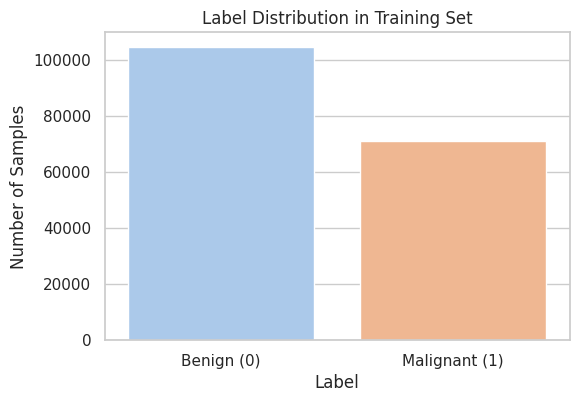

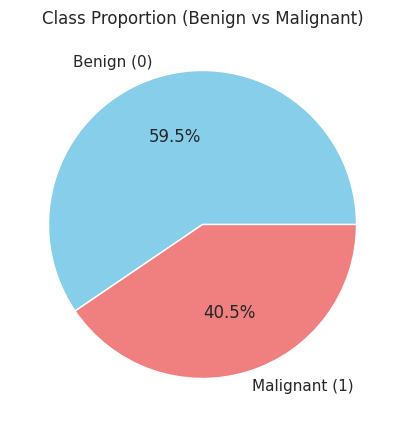

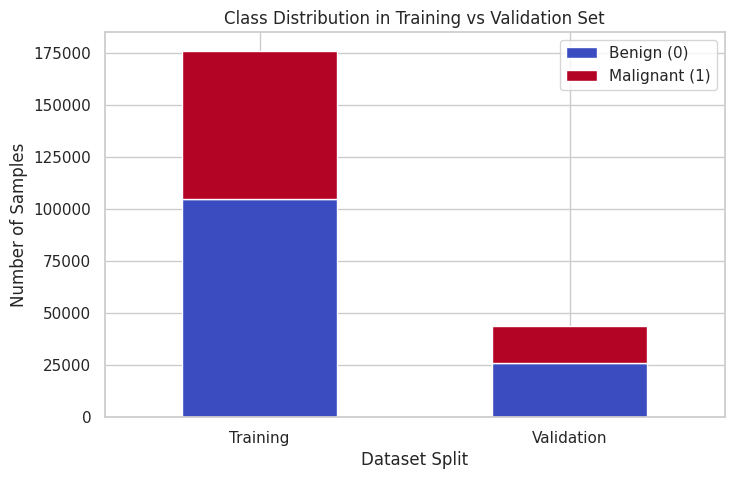

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
sns.set(style="whitegrid")

# 1. Bar plot of class distribution (Benign vs Malignant)
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_df, palette='pastel')
plt.title('Label Distribution in Training Set')
plt.xticks([0, 1], ['Benign (0)', 'Malignant (1)'])
plt.xlabel('Label')
plt.ylabel('Number of Samples')
plt.show()

# 2. Pie chart for class proportion
label_counts = train_df['label'].value_counts()
plt.figure(figsize=(5, 5))
plt.pie(label_counts, labels=['Benign (0)', 'Malignant (1)'], autopct='%1.1f%%', colors=['skyblue', 'lightcoral'])
plt.title('Class Proportion (Benign vs Malignant)')
plt.show()

# 3. Bar plot showing class distribution in training vs validation set
split_dist = pd.DataFrame({
    'Training': train_df['label'].value_counts(),
    'Validation': val_df['label'].value_counts()
}).T

split_dist.plot(kind='bar', stacked=True, figsize=(8, 5), colormap='coolwarm')
plt.title('Class Distribution in Training vs Validation Set')
plt.xlabel('Dataset Split')
plt.ylabel('Number of Samples')
plt.xticks(rotation=0)
plt.legend(['Benign (0)', 'Malignant (1)'])
plt.show()

Displaying sample images from training set:


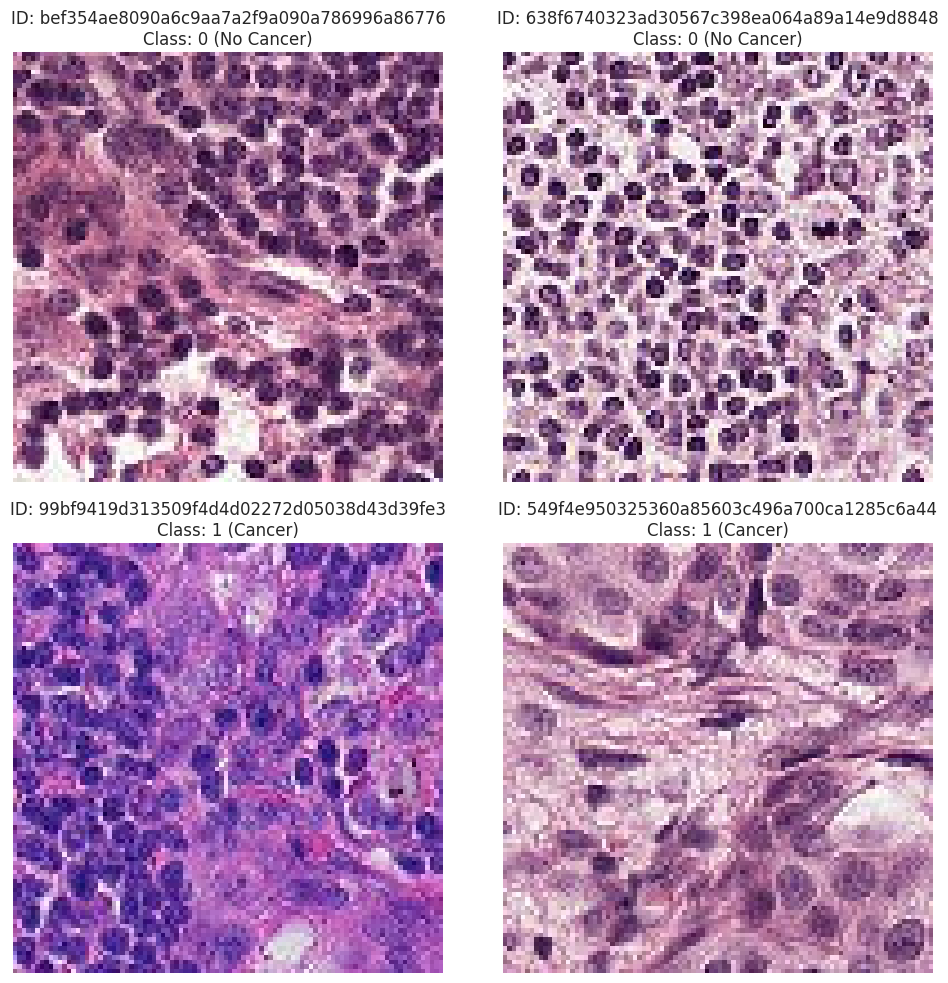


Class distribution in the original training labels:
label
0    130908
1     89117
Name: count, dtype: int64

Class distribution in the split training set (train_df):
label
0    104726
1     71294
Name: count, dtype: int64

Class distribution in the split validation set (val_df):
label
0    26182
1    17823
Name: count, dtype: int64

Basic image statistics (dimensions from a few samples in train_df):
Image ID: 917b27fe4601e0d2fc1ca7cfeb80875ef002c2d4, Class: 1, Dimensions: (96, 96), Mode: RGB
Image ID: 8f17b38881fc95bc8f45b68ddaabf7e3c67e0002, Class: 0, Dimensions: (96, 96), Mode: RGB
Image ID: 85f169c3e2509e31299d61c71aa97519b0c03080, Class: 0, Dimensions: (96, 96), Mode: RGB
Image ID: 2ea4500317828910b9ec8e44bdd9b78830934a4b, Class: 1, Dimensions: (96, 96), Mode: RGB


In [5]:
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import os
import pandas as pd

# train_images_dir, train_df, val_df, and train_labels_df should be defined from running cell 5.
# The line that previously redefined train_images_dir here has been removed.

# Function to display sample images
def display_sample_images(df, image_dir, num_samples=2):
    plt.figure(figsize=(10, 5 * num_samples // 2))
    # Get samples from both classes if possible
    samples_class_0 = df[df['label'] == 0].sample(min(num_samples // 2, len(df[df['label'] == 0])))
    samples_class_1 = df[df['label'] == 1].sample(min(num_samples // 2, len(df[df['label'] == 1])))
    
    samples_to_display = pd.concat([samples_class_0, samples_class_1])
    if samples_to_display.empty:
        print("No samples to display. Check your DataFrame and image directory.")
        return

    for i, (idx, row) in enumerate(samples_to_display.iterrows()):
        img_id = row['id']
        label = row['label']
        img_path = os.path.join(image_dir, f'{img_id}.tif')
        
        try:
            img = Image.open(img_path)
            plt.subplot(num_samples // 2, 2, i + 1)
            plt.imshow(img)
            plt.title(f"ID: {img_id}\nClass: {label} ({'No Cancer' if label == 0 else 'Cancer'})")
            plt.axis('off')
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
    plt.tight_layout()
    plt.show()

print("Displaying sample images from training set:")
# Display 4 samples (2 from each class if available)
# This will now use train_images_dir from cell 5
display_sample_images(train_df, train_images_dir, num_samples=4) 

# Check class distribution using the DataFrame
print("\nClass distribution in the original training labels:")
print(train_labels_df['label'].value_counts())

print("\nClass distribution in the split training set (train_df):")
print(train_df['label'].value_counts())

print("\nClass distribution in the split validation set (val_df):")
print(val_df['label'].value_counts())

# Basic image statistics (dimensions of a few samples)
print("\nBasic image statistics (dimensions from a few samples in train_df):")
if not train_df.empty:
    for i in range(min(4, len(train_df))): # Check up to 4 images
        sample_row = train_df.sample(1).iloc[0]
        img_id = sample_row['id']
        label = sample_row['label']
        # This will now use train_images_dir from cell 5
        img_path = os.path.join(train_images_dir, f'{img_id}.tif')
        try:
            img = Image.open(img_path)
            print(f"Image ID: {img_id}, Class: {label}, Dimensions: {img.size}, Mode: {img.mode}")
        except FileNotFoundError:
            print(f"Image not found: {img_path}")
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
else:
    print("train_df is empty, cannot display image statistics.")

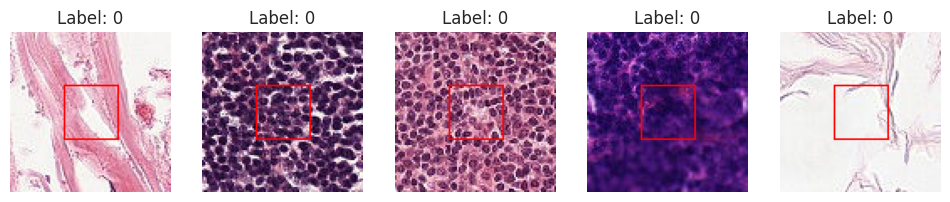

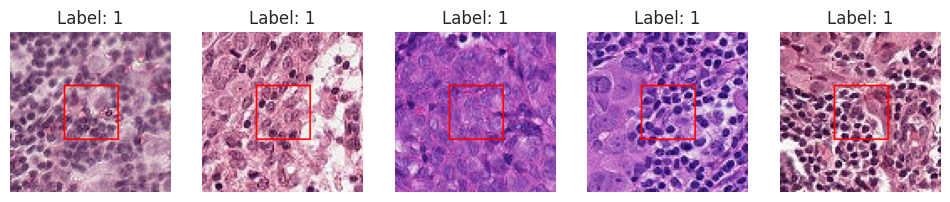

image size: (96, 96)
image mode: RGB


In [6]:
### show sample image files
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from pathlib import Path

train_dir = Path("/kaggle/input/histopathologic-cancer-detection/train")
train_labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
train_labels['path'] = train_labels['id'].apply(lambda x: str(train_dir / f'{x}.tif'))

def show_samples(label, df=train_labels, num_images=5):
    subset = df[df['label'] == label].sample(num_images, random_state=42)
    plt.figure(figsize=(12, 4))
    for i, row in enumerate(subset.itertuples()):
        img = cv2.imread(row.path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        center = (32, 32, 64, 64)  
        cv2.rectangle(img, (center[0], center[1]), (center[2], center[3]), (255, 0, 0), 1)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.title(f'Label: {row.label}')
        plt.axis('off')
    plt.show()


show_samples(0)  # Non-cancer
show_samples(1)  # Cancer

# check image size and channel
img_path = f"/kaggle/input/histopathologic-cancer-detection/train/{train_labels['id'].iloc[0]}.tif"
img = Image.open(img_path)
print(f"image size: {img.size}") 
print(f"image mode: {img.mode}")

## 4. Preprocess Dataset for Dinov2

Now, we preprocess the dataset to be compatible with the Dinov2 model. This involves resizing the images, normalizing pixel values according to Dinov2's requirements, and creating PyTorch DataLoaders for efficient batching during training and evaluation.

In [7]:
import torch
from torchvision import transforms # Removed datasets as ImageFolder is not used
from torch.utils.data import DataLoader, Dataset # Added Dataset
from PIL import Image # For loading images in the custom dataset
import os # Ensure os is imported
import pandas as pd # Ensure pandas is imported for DataFrame operations
from sklearn.model_selection import train_test_split # For stratified splitting if needed

# train_images_dir, train_df, and val_df are defined in cell 5
# However, we will now re-create train_df and val_df from the original train_labels_df for subsetting
# IMG_SIZE is defined here, or could be moved to a config section
IMG_SIZE = 224 

# --- Subsetting the dataset ---
# Load the original full training labels dataframe again to ensure we start fresh for subsetting
original_train_labels_df = pd.read_csv(os.path.join(base_dir, 'train_labels.csv'))

# Define desired number of samples
num_total_samples = 30000
train_ratio = 0.8
num_train_samples_target = int(num_total_samples * train_ratio) # 2400
num_val_samples_target = num_total_samples - num_train_samples_target # 600

print(f"Targeting {num_train_samples_target} training samples and {num_val_samples_target} validation samples.")

# Create a smaller, stratified subset for training
# First, ensure we have enough samples in each class for the target split
# If not, we might need to adjust or take all available for the smaller class
# For simplicity, we'll try to sample proportionally. If a class has fewer than target/2, it will take all of them.

# Stratified split from the original_train_labels_df to get a pool of 3000 images first
if len(original_train_labels_df) > num_total_samples:
    pool_df, _ = train_test_split(
        original_train_labels_df, 
        train_size=num_total_samples, 
        stratify=original_train_labels_df['label'], 
        random_state=42
    )
else:
    pool_df = original_train_labels_df # Use all data if it's less than 3000

# Now, split this pool_df into train_df and val_df
train_df, val_df = train_test_split(
    pool_df, 
    train_size=num_train_samples_target, # Target for train from the pool
    stratify=pool_df['label'], 
    random_state=42
)

# Adjust val_df size if the split didn't perfectly match num_val_samples_target due to pool size
if len(val_df) > num_val_samples_target:
    val_df = val_df.sample(n=num_val_samples_target, random_state=42) # Further subsample if val is too large

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

print(f"Actual subset sizes: {len(train_df)} training images, {len(val_df)} validation images.")
print("Training set class distribution:")
print(train_df['label'].value_counts())
print("Validation set class distribution:")
print(val_df['label'].value_counts())
# --- End of subsetting ---


# Define a custom Dataset
class PCamDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame with 'id' and 'label' columns.
            image_dir (str): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_id = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('id')]
        label = self.dataframe.iloc[idx, self.dataframe.columns.get_loc('label')]
        
        img_name = os.path.join(self.image_dir, f"{img_id}.tif")
        
        try:
            image = Image.open(img_name).convert("RGB") # Ensure image is RGB
        except FileNotFoundError:
            print(f"ERROR: Image not found at {img_name} for id {img_id}. Check image_dir and dataframe.")
            # Return a placeholder or raise an error. For now, let's raise it to stop execution.
            raise FileNotFoundError(f"Image not found: {img_name}")
        except Exception as e:
            print(f"ERROR: Could not load image {img_name}: {e}")
            raise

        if self.transform:
            image = self.transform(image)
        
        return image, int(label)

# Dinov2 preprocessing / Standard ImageNet normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Transform for the unlabeled test set (if used for prediction later)
    'test_data': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Create custom datasets using the new subsetted train_df and val_df
# train_images_dir should be /kaggle/input/histopathologic-cancer-detection/train
image_datasets = {
    'train': PCamDataset(dataframe=train_df, image_dir=train_images_dir, transform=data_transforms['train']),
    'val': PCamDataset(dataframe=val_df, image_dir=train_images_dir, transform=data_transforms['val'])
}

# Create DataLoaders
BATCH_SIZE = 32 # Adjust based on your GPU memory. 
                # If using multiple GPUs (e.g., with DataParallel), you might be able to increase this.
                # With a smaller dataset (3000 images), 32 should be fine, might even increase if memory allows.
dataloaders = {x: DataLoader(image_datasets[x],
                                batch_size=BATCH_SIZE,
                                shuffle=True if x == 'train' else False,
                                num_workers=2) # Adjust num_workers based on your system
               for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
# Class names are implicitly [0, 1] based on the labels in the CSV.
# If you need explicit class names for plotting or reports later, define them:
class_names = ['0', '1'] # Or ['No Cancer', 'Cancer'] if preferred for display

print(f"Class names used: {class_names}")
print(f"Dataset sizes: Train: {dataset_sizes['train']}, Val: {dataset_sizes['val']}")
print(f"Number of training batches: {len(dataloaders['train'])}")
print(f"Number of validation batches: {len(dataloaders['val'])}")

# For now, we will set test_dataloader to None as it's not strictly needed for training/validation loop
test_dataloader = None
print("test_dataloader is set to None. Modify above if predictions on Kaggle test set are needed.")

# Verify a sample from the dataloader
if dataloaders['train'] and len(dataloaders['train']) > 0:
    try:
        sample_inputs, sample_labels = next(iter(dataloaders['train']))
        print(f"Sample batch - Inputs shape: {sample_inputs.shape}, Labels shape: {sample_labels.shape}")
    except Exception as e:
        print(f"Error when trying to get a sample batch from train dataloader: {e}")
        print("This might indicate an issue with PCamDataset or the underlying data.")
elif not dataloaders['train']:
    print("Train dataloader is not initialized.")
else:
    print("Train dataloader is empty. This likely means the training dataset (train_df) is empty after subsetting.")

Targeting 24000 training samples and 6000 validation samples.
Actual subset sizes: 24000 training images, 6000 validation images.
Training set class distribution:
label
0    14279
1     9721
Name: count, dtype: int64
Validation set class distribution:
label
0    3570
1    2430
Name: count, dtype: int64
Class names used: ['0', '1']
Dataset sizes: Train: 24000, Val: 6000
Number of training batches: 750
Number of validation batches: 188
test_dataloader is set to None. Modify above if predictions on Kaggle test set are needed.
Sample batch - Inputs shape: torch.Size([32, 3, 224, 224]), Labels shape: torch.Size([32])


## 5. Load Dinov2 Model

We will load a pre-trained Dinov2 model. Dinov2 models are powerful vision transformers trained using self-supervised learning. We can use them as feature extractors or fine-tune them for specific downstream tasks like PCam classification. Here, we'll load a `dinov2_vits14` model and adapt its classification head for our binary classification problem.

In [8]:
import torch.nn as nn

# Load a pre-trained Dinov2 model
# Available models: dinov2_vits14, dinov2_vitb14, dinov2_vitl14, dinov2_vitg14
# We'll use dinov2_vits14 as an example. It's smaller and faster to train.
dinov2_model_name = 'dinov2_vits14' # Small model
# dinov2_model_name = 'dinov2_vitb14' # Base model

# Using torch.hub to load the model
# Ensure you have the dinov2 repository cloned and in your sys.path as done in step 1
try:
    model = torch.hub.load('facebookresearch/dinov2', dinov2_model_name)
except Exception as e:
    print(f"Error loading model from torch.hub: {e}")
    print("Make sure the dinov2 repository is correctly cloned and accessible.")
    # Fallback or alternative loading if needed, e.g. using timm if the model is available there
    # import timm
    # model = timm.create_model('vit_small_patch14_dinov2.lvd142m', pretrained=True)
    raise e

# Dinov2 models from torch.hub usually don't have a classification head suitable for direct fine-tuning
# or the head is for ImageNet (1000 classes). We need to replace it or use the model as a feature extractor.

# Option 1: Use as a feature extractor and add a new classifier head
# The feature dimension for dinov2_vits14 is 384
# For dinov2_vitb14, it's 768
feature_dim = model.embed_dim # This should give the feature dimension

# Freeze the backbone (Dinov2) parameters
for param in model.parameters():
    param.requires_grad = False

# Define a new classification head
num_classes = len(class_names) # Should be 2 for PCam (Cancer/No Cancer)
classifier_head = nn.Linear(feature_dim, num_classes)

# Combine the Dinov2 backbone with the new head
# Some Dinov2 hub models might return features directly, others might have a `head` attribute.
# If it has a `head` attribute, we replace it.
if hasattr(model, 'head') and isinstance(model.head, nn.Linear):
    model.head = classifier_head
    print(f"Replaced model.head with a new Linear layer for {num_classes} classes.")
else:
    # If no head attribute or it's not what we expect, create a sequential model
    # This assumes the base Dinov2 model outputs features directly from its forward pass
    # or we need to call a specific method like `model.forward_features()`
    # For torch.hub.load('facebookresearch/dinov2', ...), the model itself is the backbone.
    # We need to wrap it if we want to append a head and treat it as a single nn.Module for training.
    class Dinov2WithHead(nn.Module):
        def __init__(self, backbone, head):
            super().__init__()
            self.backbone = backbone
            self.head = head
        
        def forward(self, x):
            # The backbone might return a dict or a tensor
            # For Dinov2, it often returns a dict like {'x_norm_patchtokens': ..., 'x_norm_clstoken': ...}
            # We are interested in the CLS token for classification
            features = self.backbone.forward_features(x)
            # Try to get CLS token, otherwise use patch tokens (might need pooling)
            if isinstance(features, dict) and 'x_norm_clstoken' in features:
                cls_token = features['x_norm_clstoken']
            elif isinstance(features, dict) and 'x_norm_patchtokens' in features: # Fallback: average patch tokens
                patch_tokens = features['x_norm_patchtokens']
                cls_token = torch.mean(patch_tokens, dim=1) # Average pool patch tokens
            elif torch.is_tensor(features):
                # If it's a tensor, assume it's [batch_size, num_tokens, embed_dim]
                # and the first token is the CLS token, or we average pool
                # This depends on the specific Dinov2 variant from torch.hub
                # For safety, let's assume we need to average if it's not a dict with clstoken
                if features.ndim == 3:
                    cls_token = torch.mean(features, dim=1)
                else:
                    cls_token = features # Assume it's already [batch_size, embed_dim]
            else:
                raise ValueError(f"Unexpected feature output format from Dinov2 backbone: {type(features)}")
            
            return self.head(cls_token)

    model = Dinov2WithHead(model, classifier_head)
    print(f"Wrapped Dinov2 backbone with a new Linear layer for {num_classes} classes.")

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check for multiple GPUs and use DataParallel
if torch.cuda.device_count() > 1:
    print(f"Let's use {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)
    print("Model wrapped with nn.DataParallel.")

print(f"Model: {dinov2_model_name} loaded and adapted for {num_classes}-class classification.")
print(f"Using device: {device}")
# print(model) # Uncomment to see model structure

Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dinov2_vits14_pretrain.pth
100%|██████████| 84.2M/84.2M [00:00<00:00, 121MB/s] 


Wrapped Dinov2 backbone with a new Linear layer for 2 classes.
Let's use 2 GPUs!
Model wrapped with nn.DataParallel.
Model: dinov2_vits14 loaded and adapted for 2-class classification.
Using device: cuda:0


## 6. Train Dinov2 on PCam Dataset

In this section, we will train (fine-tune the head of) the Dinov2 model on the PCam dataset. We will define a loss function (CrossEntropyLoss for classification) and an optimizer (AdamW). The training loop will iterate through the data, perform forward and backward passes, and update the model weights. We will also monitor validation accuracy to save the best performing model.

Optimizing only the parameters of the custom classifier head (original_model.head).
Starting model training...
Epoch 1/10
----------
train Loss: 0.3524 Acc: 0.8465
val Loss: 0.3171 Acc: 0.8648
Best validation accuracy improved to 0.8648. Model saved.
Epoch 1 completed in 3m 31s

Epoch 2/10
----------
train Loss: 0.3249 Acc: 0.8622
val Loss: 0.3182 Acc: 0.8617
Epoch 2 completed in 2m 38s

Epoch 3/10
----------
train Loss: 0.3113 Acc: 0.8672
val Loss: 0.3123 Acc: 0.8702
Best validation accuracy improved to 0.8702. Model saved.
Epoch 3 completed in 2m 40s

Epoch 4/10
----------
train Loss: 0.3103 Acc: 0.8705
val Loss: 0.2985 Acc: 0.8772
Best validation accuracy improved to 0.8772. Model saved.
Epoch 4 completed in 2m 36s

Epoch 5/10
----------
train Loss: 0.3089 Acc: 0.8714
val Loss: 0.3109 Acc: 0.8697
Epoch 5 completed in 2m 37s

Epoch 6/10
----------
train Loss: 0.3054 Acc: 0.8710
val Loss: 0.2911 Acc: 0.8783
Best validation accuracy improved to 0.8783. Model saved.
Epoch 6 completed in

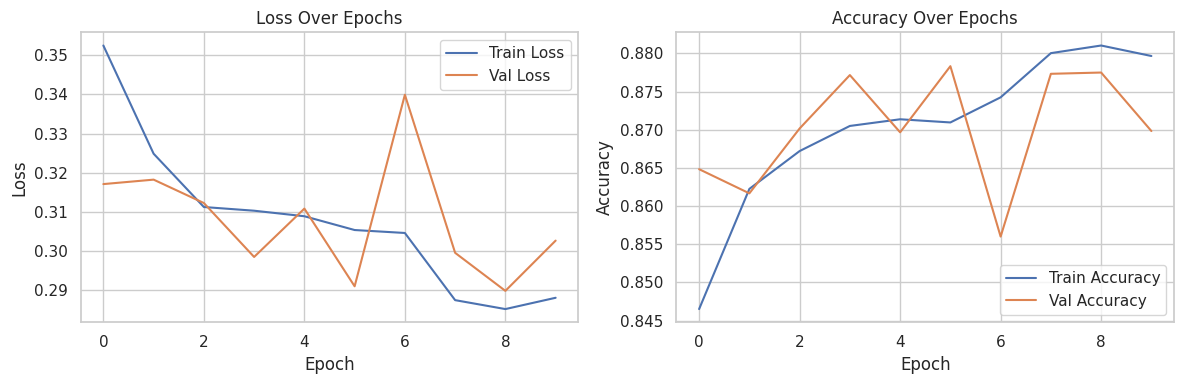

In [9]:
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy
import torch.nn as nn # Ensure nn is imported for DataParallel check

# Define loss function and optimizer

# Access the original model if wrapped by DataParallel
original_model = model.module if isinstance(model, nn.DataParallel) else model

# Only training the classifier head, so pass only its parameters to the optimizer
if isinstance(original_model, Dinov2WithHead):
    optimizer = optim.AdamW(original_model.head.parameters(), lr=1e-3, weight_decay=1e-4)
    print("Optimizing only the parameters of the custom classifier head (original_model.head).")
elif hasattr(original_model, 'head') and isinstance(original_model.head, nn.Linear):
    optimizer = optim.AdamW(original_model.head.parameters(), lr=1e-3, weight_decay=1e-4)
    print("Optimizing only the parameters of original_model.head.")
else:
    # This case should ideally not be hit if model adaptation was correct
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, original_model.parameters()), lr=1e-3, weight_decay=1e-4)
    print("Warning: Optimizing all parameters of original_model with requires_grad=True. Ensure this is intended.")

criterion = nn.CrossEntropyLoss()

# Learning rate scheduler (optional, but often helpful)
# Reduce learning rate when a metric has stopped improving
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    overall_start_time = time.time() # Record start time for overall training
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        epoch_start_time = time.time() # Record start time for the current epoch
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            if phase == 'train':
                scheduler.step() # Step the learning rate scheduler

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_acc'].append(epoch_acc.item()) # .item() to get Python number

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model if it's the best validation accuracy so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                # Save the best model checkpoint
                torch.save(model.state_dict(), 'dinov2_pcam_best_model.pth')
                print(f"Best validation accuracy improved to {best_acc:.4f}. Model saved.")
        
        epoch_time_elapsed = time.time() - epoch_start_time
        print(f"Epoch {epoch+1} completed in {epoch_time_elapsed // 60:.0f}m {epoch_time_elapsed % 60:.0f}s")
        print()

    overall_time_elapsed = time.time() - overall_start_time
    print(f'Overall training complete in {overall_time_elapsed // 60:.0f}m {overall_time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

# Start training
# Consider a small number of epochs first to ensure everything runs correctly.
NUM_EPOCHS = 10 # Adjust as needed. For good results, more epochs might be required.

print("Starting model training...")
model_ft, training_history = train_model(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(training_history['train_loss'], label='Train Loss')
plt.plot(training_history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

plt.subplot(1, 2, 2)
plt.plot(training_history['train_acc'], label='Train Accuracy')
plt.plot(training_history['val_acc'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')
plt.tight_layout()
plt.show()

## 7. Evaluate the Model

After training, we evaluate the performance of our fine-tuned Dinov2 model on the validation set (or a dedicated test set if available and prepared). We will calculate metrics such as accuracy, precision, recall, F1-score, and visualize a confusion matrix.

Evaluating the model on the validation set...

Classification Report (Validation Set):
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      3570
           1       0.86      0.83      0.85      2430

    accuracy                           0.88      6000
   macro avg       0.88      0.87      0.87      6000
weighted avg       0.88      0.88      0.88      6000


Confusion Matrix (Validation Set):


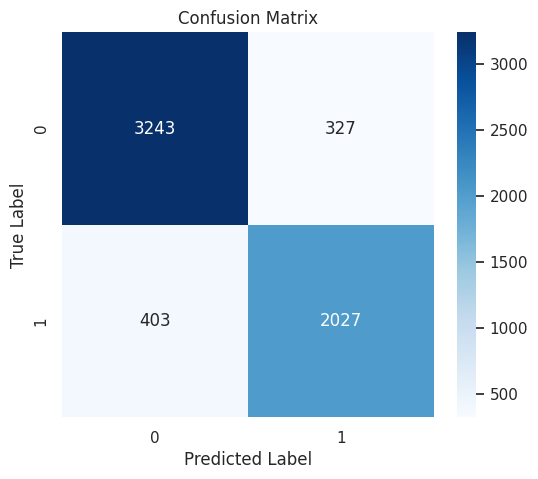


Visualizing some predictions from the validation set:


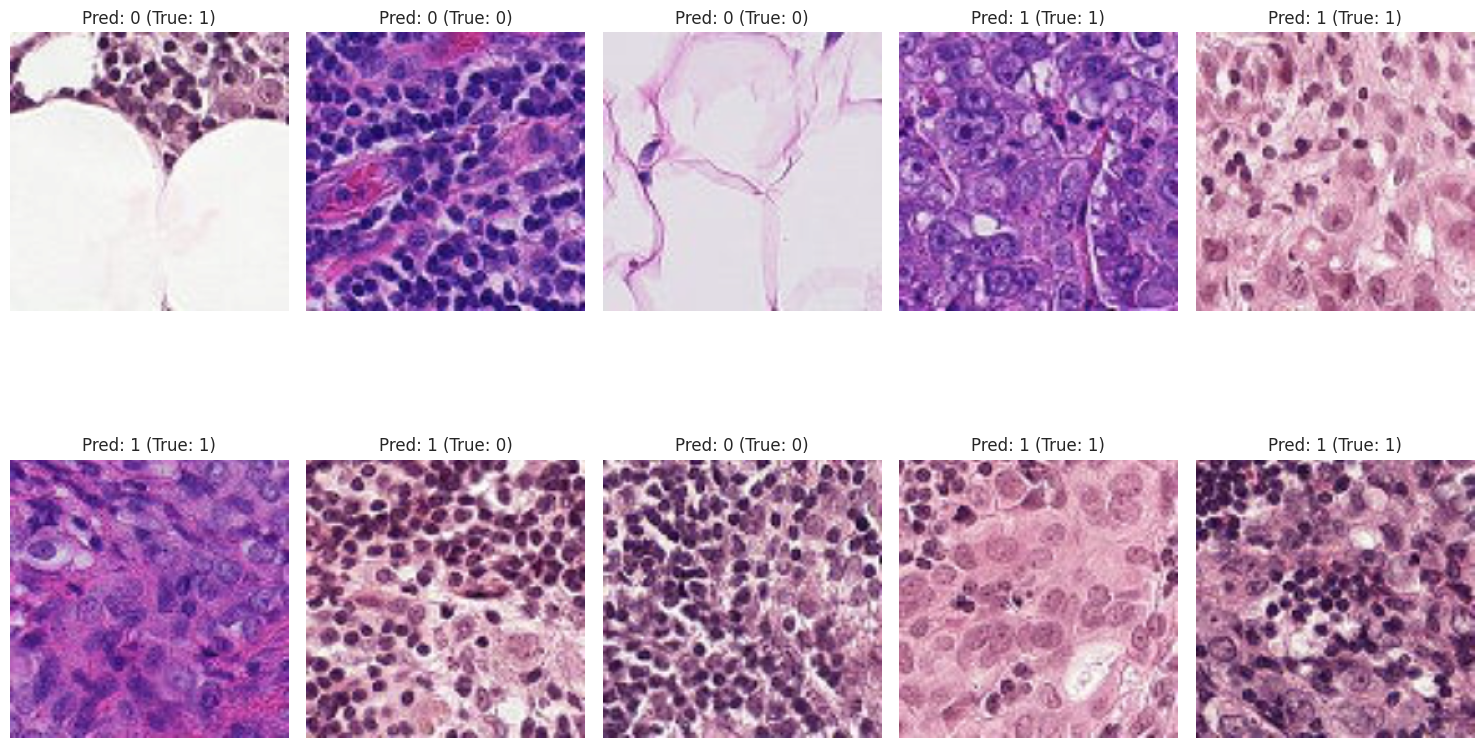

In [10]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Function to evaluate the model
def evaluate_model(model, dataloader):
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad(): # No need to track gradients during evaluation
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)

print("Evaluating the model on the validation set...")
val_labels, val_preds = evaluate_model(model_ft, dataloaders['val'])

# Classification Report
print("\nClassification Report (Validation Set):")
# Ensure class_names are strings if they are not already for classification_report
str_class_names = [str(cn) for cn in class_names]
print(classification_report(val_labels, val_preds, target_names=str_class_names))

# Confusion Matrix
print("\nConfusion Matrix (Validation Set):")
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=str_class_names, yticklabels=str_class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# Visualize some predictions (optional)
def visualize_predictions(model, dataloader, num_images=10):
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 10))
    
    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images // 5 + (1 if num_images % 5 > 0 else 0), 5, images_so_far)
                ax.axis('off')
                ax.set_title(f'Pred: {class_names[preds[j]]} (True: {class_names[labels[j]]})')
                # Inverse normalize and display image
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                mean = np.array([0.485, 0.456, 0.406])
                std = np.array([0.229, 0.224, 0.225])
                img = std * img + mean
                img = np.clip(img, 0, 1)
                plt.imshow(img)
                
                if images_so_far == num_images:
                    plt.tight_layout()
                    plt.show()
                    return
    plt.tight_layout()
    plt.show()

print("\nVisualizing some predictions from the validation set:")
visualize_predictions(model_ft, dataloaders['val'], num_images=10)

## 8. Save the Trained Model

Finally, we save the state dictionary of our best performing fine-tuned model. This allows us to load it later for inference or further training without needing to repeat the entire training process.

In [11]:
# The best model was already saved during training as 'dinov2_pcam_best_model.pth'
# Here we can explicitly save the final model if needed, or re-save the best one for clarity.
final_model_path = "dinov2_pcam_final_trained_model.pth"
torch.save(model_ft.state_dict(), final_model_path)
print(f"Final trained model state dictionary saved to: {final_model_path}")

# To load the model later:
# 1. Re-define the model architecture (as done in Section 5)
#    model_to_load = ... (same architecture as model_ft)
# 2. Load the state dictionary:
#    model_to_load.load_state_dict(torch.load(final_model_path, map_location=device))
#    model_to_load.eval() # Set to evaluation mode

Final trained model state dictionary saved to: dinov2_pcam_final_trained_model.pth


## 9. Conclusion and Expected Results

This notebook demonstrated a pipeline for classifying PCam histopathological images using a pre-trained Dinov2 model. We covered:
1.  Setting up the environment and cloning Dinov2.
2.  Downloading and organizing the PCam dataset.
3.  Performing basic EDA.
4.  Preprocessing images and creating DataLoaders.
5.  Loading a Dinov2 model (`dinov2_vits14`) and adapting its head for binary classification.
6.  Training the new classification head while keeping the Dinov2 backbone frozen.
7.  Evaluating the model using accuracy, classification report, and confusion matrix.
8.  Saving the trained model.

**Expected Results:**

*   **Performance:** Using a powerful pre-trained model like Dinov2, even with just fine-tuning the head, can yield strong results on medical image datasets like PCam. Accuracy can be expected to be significantly above random chance and often competitive with models trained from scratch with extensive data, especially when training data is limited. For PCam, accuracies in the range of 90-98% have been reported with various CNN and Transformer architectures, depending on the exact preprocessing, augmentation, model size, and training regime.
*   **Feature Extraction Power:** Dinov2's self-supervised pre-training allows it to learn robust and generalizable visual features. This is particularly beneficial for specialized domains like medical imaging where large labeled datasets might be scarce.
*   **Training Efficiency:** By freezing the backbone and only training a small classifier head, training can be relatively fast and require less computational resources compared to full fine-tuning of a large transformer.

**Potential Improvements:**

*   **Full Fine-tuning:** Unfreeze some or all layers of the Dinov2 backbone for further fine-tuning. This might yield better performance but requires more data and computational resources, and careful hyperparameter tuning (e.g., lower learning rates for the backbone).
*   **Larger Dinov2 Models:** Experiment with larger Dinov2 variants (e.g., `dinov2_vitb14`, `dinov2_vitl14`) if computational resources allow. These models have higher capacity but also require more memory and time to train.
*   **Advanced Augmentation:** Explore more sophisticated data augmentation techniques specific to histopathological images.
*   **Hyperparameter Optimization:** Systematically tune hyperparameters like learning rate, batch size, optimizer settings, and scheduler parameters.
*   **Cross-Validation:** Use k-fold cross-validation for a more robust estimate of model performance.
*   **Test Set Evaluation:** If a dedicated labeled test set is available (separate from the validation set used for model selection), evaluate the final model on it for an unbiased performance measure. The current notebook uses the Kaggle `test` folder which is unlabeled; predictions would typically be submitted to Kaggle for scoring.

This notebook provides a solid foundation for using Dinov2 for image classification tasks.